# Fine-tuning models

Note: before running code in this notebook, make sure GPU is being used. Go to edit > notebook settings > and select GPU under Hardware accelerator

Model used in this notebook:

In [ ]:
model_checkpoint = 'distilbert-base-uncased'
# specify i.f.f. you are using a fine-tuned model (ex: legalbert)
# replace instances of "model_checkpoint" with "matching tokenizer" when reading in tokenizers
#matching_tokenizer = 'bert-base-uncased' 

Repo to write the final model to; change name based on the base model specified above

In [ ]:
hub_model_id = f'repro-rights-amicus-briefs/{model_checkpoint}-finetuned-RRamicus'

# Set up environment

1. Load required packages
2. Log into HuggingFace w/access token
3. Load dataset from HuggingFace website

In [ ]:
! pip install transformers
! pip install torch
! pip install datasets

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from html import unescape
from random import randint
import math

from transformers import pipeline                                                   
from transformers.pipelines.pt_utils import KeyDataset
#import datasets
from datasets import load_dataset, load_metric, Dataset
from transformers import DataCollatorWithPadding
from transformers import AdamW
from transformers import AutoTokenizer, AutoModelForMaskedLM, TrainingArguments, Trainer
from tokenizers import normalizers
from tokenizers.normalizers import BertNormalizer
from transformers import DataCollatorForLanguageModeling

from huggingface_hub import notebook_login

import torch as torch
#from torch.nn import functional as F

Log into huggingface to access the amicus files as a transformers dataset object

In [ ]:
# run this once at the start of the session so it saves the token you enter
# in the login in the next code chunk
!git config --global credential.helper store

In [ ]:
# get access token on Huggingface website > settings > access token (make sure it's a write token)
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


Load data from HuggingFace Hub

In [ ]:
ds_path = 'repro-rights-amicus-briefs/repro-rights-amicus'
# use_auth_token must be true bc this is a private dataset
ds = load_dataset(ds_path, use_auth_token=True)

Check - should have train/test/val with at least `id` and `text` columns

In [ ]:
# check
ds

DatasetDict({
    test: Dataset({
        features: ['case', 'brief', 'id', 'text', 'brief_party'],
        num_rows: 149
    })
    valid: Dataset({
        features: ['case', 'brief', 'id', 'text', 'brief_party'],
        num_rows: 178
    })
    train: Dataset({
        features: ['case', 'brief', 'id', 'text', 'brief_party'],
        num_rows: 414
    })
})

# Pre-process inputs

Before tokenizing, we can do some very minimal text pre-processing. Though our text is already lowercase, we can do a few other, simple preprocessing steps. 

1. Remove html characters that sometimes show up in pdf/legal documents. For example, changes '&amp' to &, something transformer models can understand.
2. Lowercasing. See about using Bert normalizer later (this ensures that text has the same preprocessing steps used for text in Bert models)

In [ ]:
# remove html characters if they exist! 
ds = ds.map(
    lambda x: {"text": [unescape(o) for o in x["text"]]}, batched=True
)

# lowercase (we've already done this)
#def lowercase_condition(example):
#    return {"condition": example["condition"].lower()}
#ds = ds.map(lowercase_condition)

# normalize text for Bert
#normalizer = normalizers.BertNormalizer()

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Next, we instantiate the tokenizer. Here, using AutoTokenizer and specifying a model. Can also use the correct tokenizer for our model directly. AutoTokenizer makes sure to grab the correct tokenizer for us w/o us having to specify it.

In [ ]:
#instantiate tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Get max length for model. Use this value for max length in the tokenize_and_split function 

In [ ]:
tokenizer.model_max_length

Next, we tokenize. Note that, even though this model uses a subword tokenizer and typically less tokens are used to represent N words, many of our documents still exceed max token limits of transformer models (512). 

Since we don't want to cut off our text after the first 512 tokens, we can instead `tokenize_and_split`, which keeps the "overflow tokens". We also dont want a hard cut after 512 tokens - we want to retain some overlap in case an idea is being expressed in the middle of two splits. 

See [transformers tutorial](https://huggingface.co/course/chapter5/3?fw=pt) for more info

In [ ]:
# tokenize in split in documentation for how to break up long text
# instead of returning 1 row per tokenized text, we may instead return multiple
#   with this version, we can also save our metadata by replicating metadata across
#   all of our newly created rows
def tokenize_and_split(examples):
    result = tokenizer(
        examples["text"],
        truncation = True,
        max_length = 512,
        stride = 128,
        return_overflowing_tokens = True,
        padding = 'max_length',
        return_special_tokens_mask = True
    )
    # Extract mapping between new and old indices
    sample_map = result.pop("overflow_to_sample_mapping")
    for key, values in examples.items():
        result[key] = [values[i] for i in sample_map]
    return result

Tokenize

In [ ]:
# do the tokenizing using map function
tokenized_ds = ds.map(tokenize_and_split,
                      batched = True,
                      batch_size = 100)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

As a result, we have tokenized our train, val, and test sets

In [ ]:
tokenized_ds

DatasetDict({
    test: Dataset({
        features: ['case', 'brief', 'id', 'text', 'brief_party', 'input_ids', 'token_type_ids', 'attention_mask', 'special_tokens_mask'],
        num_rows: 3111
    })
    valid: Dataset({
        features: ['case', 'brief', 'id', 'text', 'brief_party', 'input_ids', 'token_type_ids', 'attention_mask', 'special_tokens_mask'],
        num_rows: 3821
    })
    train: Dataset({
        features: ['case', 'brief', 'id', 'text', 'brief_party', 'input_ids', 'token_type_ids', 'attention_mask', 'special_tokens_mask'],
        num_rows: 8901
    })
})

In [ ]:
tokenized_ds['train'].features

{'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'brief': Value(dtype='string', id=None),
 'brief_party': Value(dtype='int64', id=None),
 'case': Value(dtype='string', id=None),
 'id': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'special_tokens_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'text': Value(dtype='string', id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

# Train Model

Code from here is adapted from a [huggingface example notebook on language modeling](https://github.com/huggingface/notebooks/blob/master/examples/language_modeling.ipynb)

Download the model from huggingface and cache

In [ ]:
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Next, we need to add a label column to the dataset. If the task we're doing is masking a word in a sentence and predicting the word, our label is the full, complete sentence. This is the input_ids. (Not sure if this is actually used?) 

In [ ]:
def gen_label(examples):
    examples["labels"] = examples["input_ids"].copy()
    return examples


tokenized_ds = tokenized_ds.map(gen_label,
                                batched=True,
                                batch_size=500)

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

In [ ]:
# check that above worked -- we should have input_id = labels
print(tokenized_ds['train']['input_ids'][0])
print(tokenized_ds['train']['labels'][0])

[101, 1996, 11324, 2645, 2003, 1037, 4736, 2090, 1996, 4372, 17897, 9250, 2157, 2000, 2166, 1998, 1996, 16655, 19172, 16848, 2157, 2000, 11324, 1012, 3081, 8553, 14623, 2000, 2035, 5022, 1010, 2025, 2074, 16725, 1012, 3081, 8553, 5761, 1996, 3754, 2000, 7438, 1996, 5776, 2030, 10527, 1010, 2025, 1996, 16112, 6459, 2030, 8438, 1997, 1996, 5776, 2030, 10527, 1012, 3081, 8553, 3141, 2000, 21371, 16725, 2038, 2061, 5301, 2144, 3381, 2008, 2116, 5190, 1997, 16725, 2031, 3728, 2042, 11113, 15613, 2012, 5535, 2073, 2073, 2027, 2089, 2031, 2042, 2641, 2512, 14874, 1999, 3381, 1010, 2021, 2651, 2027, 2052, 2031, 1037, 2488, 2084, 3938, 1003, 3382, 2000, 5788, 2065, 5459, 2512, 14196, 2013, 2045, 2388, 1012, 3522, 9849, 1999, 2966, 2671, 5769, 2008, 2023, 2095, 1010, 2901, 1010, 4022, 3081, 8553, 2071, 2022, 2004, 2220, 2004, 1996, 2203, 1997, 1996, 2034, 12241, 20367, 1012, 1008, 8890, 2023, 4766, 15841, 9849, 1999, 3949, 1997, 5186, 21371, 3653, 10280, 4286, 2405, 2205, 2397, 2000, 2022, 14964

The task here is masked language modeling. How do we mask random tokens? Transformers library has a function that will randomly mask tokens for us! 

In [ ]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                mlm_probability=0.15)

Define the training parameters. In the template notebook, all hyperparam values (adam, lr, etc.) are set to defaults. See [huggingface trainer arguments api](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments) for more information on all available parameters.

In [ ]:
# run this to be able to push model to the hub
!apt-get install git-lfs

In [ ]:
#set training arguments
batch_size = 8
logging_steps = len(ds["train"]) // batch_size

training_args = TrainingArguments('test-trainer',
                                  logging_strategy='epoch',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  report_to='all',
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end = True,
                                  push_to_hub=True,
                                  hub_model_id=hub_model_id,
                                  #output_dir=f'{model_checkpoint}-finetuned-RRamicus',
                                  overwrite_output_dir=True,
                                  logging_steps=logging_steps,
                                  seed=928,
                                  metric_for_best_model="loss", # default
                                  # parameters to tweak
                                  learning_rate=2e-5,
                                  num_train_epochs=10,
                                  optim='adamw_hf', 
                                  weight_decay=0.01,
                                  adam_beta1=0.9,
                                  adam_beta2=0.999,
                                  adam_epsilon=1e-8)

#setup training loop with arguments
trainer = Trainer(model = model, 
                  args = training_args,
                  data_collator = data_collator,
                  tokenizer = tokenizer,
                  train_dataset = tokenized_ds['train'],
                  eval_dataset = tokenized_ds['valid'])

PyTorch: setting up devices
Cloning https://huggingface.co/repro-rights-amicus-briefs/distilbert-base-uncased-finetuned-RRamicus into local empty directory.


Train!

Before running this, go to Edit -> Notebook Settings and make sure to select GPU under "Hardware accelerator"

For distilbert, takes 1hr 9 min

In [ ]:
#train
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: token_type_ids, text, case, brief, id, special_tokens_mask, brief_party.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8901
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11130


Epoch,Training Loss,Validation Loss
1,2.219600,1.972261
2,2.012000,1.880214
3,1.922900,1.814811
4,1.859100,1.786366
5,1.808600,1.751244
6,1.779800,1.726093
7,1.747900,1.717723
8,1.725300,1.695521
9,1.710900,1.671211
10,1.703800,1.687007


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: token_type_ids, text, case, brief, id, special_tokens_mask, brief_party.
***** Running Evaluation *****
  Num examples = 3821
  Batch size = 8
Saving model checkpoint to test-trainer/checkpoint-1113
Configuration saved in test-trainer/checkpoint-1113/config.json
Model weights saved in test-trainer/checkpoint-1113/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1113/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1113/special_tokens_map.json
tokenizer config file saved in test-trainer/tokenizer_config.json
Special tokens file saved in test-trainer/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: token_type_ids, text, case, brief, id, special_tokens_mask, brief_party.
***** Running Evalua

TrainOutput(global_step=11130, training_loss=1.8489897118745788, metrics={'train_runtime': 4198.1531, 'train_samples_per_second': 21.202, 'train_steps_per_second': 2.651, 'total_flos': 1.179926850410496e+16, 'train_loss': 1.8489897118745788, 'epoch': 10.0})

In [ ]:
# if run into cuda out of memory error, try
# this first
#torch.cuda.empty_cache()
# and if no change, try this
#import gc
#del trainer
#gc.collect()

# Evaluate trained model

The main metrics used to evaluate language models are:

* [perplexity](https://huggingface.co/docs/transformers/perplexity): P(word | context, aka, k-1 preceeding tokens) = P($X_k$ | $X_{<k}$)
   - lower values are better 
   - is actually just e^(-average(CE))
   - a huggingface tutorial called a value of 21 "somewhat larger" and this is the only frame of reference I have at this point
* cross entropy loss
  - lower values better
  - doesn't give us more info if we compute perplexity


## Model 1

In [ ]:
eval_valid = trainer.evaluate(tokenized_ds['valid'])
print(f"Perplexity: {math.exp(eval_valid['eval_loss']):.2f}")

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: token_type_ids, text, case, brief, id, special_tokens_mask, brief_party.
***** Running Evaluation *****
  Num examples = 3821
  Batch size = 8


Perplexity: 5.40


In [ ]:
eval_test = trainer.evaluate(tokenized_ds['test'])
print(f"Perplexity: {math.exp(eval_test['eval_loss']):.2f}")

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: token_type_ids, text, case, brief, id, special_tokens_mask, brief_party.
***** Running Evaluation *****
  Num examples = 3111
  Batch size = 8


Perplexity: 5.44


## Model 2

# Push final model to hub

In [ ]:
trainer.push_to_hub(hub_model_id, use_auth_token=True, private=True)

# Cross-model comparison task

Using the model with the highest perplexity score, check the accuracy on our labeled dataset

## Read in manually labeled dataset

Set up drive access & read in csv

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My\ Drive/amicus-iv

Mounted at /content/gdrive
/content/gdrive/My Drive/amicus-iv


In [ ]:
# pd DataFrame
eval_df = pd.read_csv('data/evaluation_dataset.csv')

# turn labels column into a list (is currently a string with labels sep by col)
eval_df['labels'] = eval_df['labels'].str.replace("women's citizenship", "woman's citizenship")
eval_df["labels"] = [x.split(', ') for x in eval_df['labels']]

# Dataset
eval_ds = Dataset.from_pandas(eval_df)
eval_ds.features

{'brief': Value(dtype='string', id=None),
 'brief_party': Value(dtype='int64', id=None),
 'case': Value(dtype='string', id=None),
 'id': Value(dtype='float64', id=None),
 'labels': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'text': Value(dtype='string', id=None)}

## Predict using classification pipeline

In [ ]:
# hyp template
hyp_temp = 'This example is about {}.'

# set up labels
labels_fem = ["women's rights", "undue burden", "compulsory motherhood", "woman's citizenship", "evidence", "health"]
#labels_fem = ['abortion is women\'s rights', 'undue burden standard', 'forces motherhood', 'evidence', 'health']
labels_opp = ["morality", "abortion negative", "psychological harm", "fetus", "evidence", "health"]
labels_all = labels_fem + labels_opp

# tokenizer 
class_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, truncation = True, max_length = 512, padding = 'max_length')

# pipeline
classifier = pipeline(task = 'zero-shot-classification', 
                      model = hub_model_id,
                      tokenizer = class_tokenizer,
                      hypothesis_template = hyp_temp,
                      batch_size = 8,
                      use_auth_token = True,
                      device = 0)

# function to apply to each element in dataset
def classifier_pipeline(example):
    # just init, should not use this category
    curr_labels = labels_all 
    if example['brief_party'] == 1:
      curr_labels = labels_fem
    else:
      curr_labels = labels_opp
    output = classifier(example['text'], curr_labels, multi_label=True, device=0)
    example['pred_labels'] = output['labels']
    example['pred_scores'] = output['scores']
    return example

In [ ]:
# run on the eval dataset
eval_ds = eval_ds.map(classifier_pipeline)

0ex [00:00, ?ex/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:978: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


## Accuracy metrics

Binarize the labels since we have multiple classes. The mlb function from sklearn turns labels (for ex: abortion negative, psy harm) into vectors (0, 1, 0, 0, 1, 0). 

In [ ]:
# binarize labels (since we have multiple classes)
from sklearn.preprocessing import MultiLabelBinarizer
# set up one for the fem briefs and one for the opp briefs
labels = labels_fem + labels_opp[:-2]
mlb = MultiLabelBinarizer(classes=labels)
#mlb_fem = MultiLabelBinarizer(classes=labels_fem)
#mlb_opp = MultiLabelBinarizer(classes=labels_opp)
mlb.fit(labels)
#mlb_fem.fit(labels_fem)
#mlb_opp.fit(labels_opp)

MultiLabelBinarizer(classes=["women's rights", 'undue burden',
                             'compulsory motherhood', "woman's citizenship",
                             'evidence', 'health', 'morality',
                             'abortion negative', 'psychological harm',
                             'fetus'])

Map the binarized labels to the text labels we have across our dataset. 

In [ ]:
# create a label_ids column for the truth
# binarize the labels 
def prepare_labels(batch):
    '''if batch['brief_party']==1:
      batch["label_ids"] = mlb_fem.transform(batch["labels"])
    else:
      batch["label_ids"] = mlb_opp.transform(batch["labels"])'''
    batch['label_ids'] = mlb.transform(batch['labels'])
    return batch

eval_ds = eval_ds.map(prepare_labels, batched=True, batch_size=20)

  0%|          | 0/6 [00:00<?, ?ba/s]

Classification report from sklearn (f1, precision, recall, etc.) 

In [ ]:
# function to get topk or threshold labels
def get_preds(example, threshold=None, topk=None):
    preds = []
    # get preds that meet threshold
    if threshold:
        for label, score in zip(example["pred_labels"], example["pred_scores"]):
            if score >= threshold:
                preds.append(label)
    # get preds that are topk highest scores
    elif topk:
        for i in range(topk):
            preds.append(example["pred_labels"][i])
    else:
        raise ValueError("Set either `threshold` or `topk`.")

    # save to dataset
    #if len(preds) > 0:
    #  example['pred_label_ids'] = list(np.squeeze(preds))
    #else:
    #  example['pred_label_ids'] = []

    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

In [ ]:
# classification report
from sklearn.metrics import classification_report
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])

    '''if ds['brief_party']==1:
      return classification_report(
          y_true, y_pred, target_names=mlb_fem.classes_, zero_division=0, 
          output_dict=True)
    else:
      return classification_report(
          y_true, y_pred, target_names=mlb_opp.classes_, zero_division=0, 
          output_dict=True)'''
      
    return classification_report(
          y_true, y_pred, target_names=mlb.classes_, zero_division=0, 
          output_dict=True)

Evaluate which of the thresholds / top k values are the best for this model. The best value will be used in the classification notebook. 

In [ ]:
# check accuracy with different topks
topk_macros, topk_micros = [], []
topks = [1, 2, 3, 4, 5, 6]
for topk in topks:
    eval_ds = eval_ds.map(get_preds, batched=False, fn_kwargs={'topk': topk})
    clf_report = get_clf_report(eval_ds)
    topk_micros.append(clf_report['micro avg']['f1-score'])
    topk_macros.append(clf_report['macro avg']['f1-score'])

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

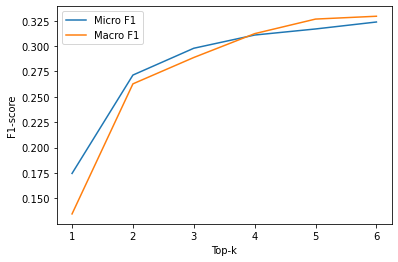

In [ ]:
plt.plot(topks, topk_micros, label='Micro F1')
plt.plot(topks, topk_macros, label='Macro F1')
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

Check the thresholds

In [ ]:
# check accuracy with different thresholds
thresh_macros, thresh_micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    eval_ds = eval_ds.map(get_preds, batched=False, fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(eval_ds)
    thresh_micros.append(clf_report["micro avg"]["f1-score"])
    thresh_macros.append(clf_report["macro avg"]["f1-score"])

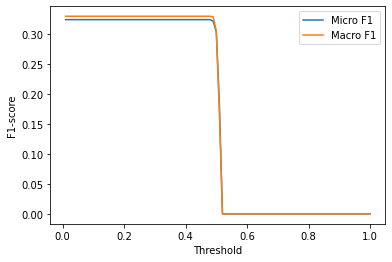

In [ ]:
plt.plot(thresholds, thresh_micros, label="Micro F1")
plt.plot(thresholds, thresh_macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()